First lets see what the data looks like

In [10]:
import pandas as pd

train_df = pd.read_csv('data_train-1.csv')
train_df.head()

,Unnamed: 0,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0,LP001518,Male,Yes,1,Graduate,No,1538,1425.0,30.0,360.0,1.0,Urban,Y
1,1,LP002734,Male,Yes,0,Graduate,No,6133,3906.0,324.0,360.0,1.0,Urban,Y
2,2,LP002697,Male,No,0,Graduate,No,4680,2087.0,NaN,360.0,1.0,Semiurban,N
3,3,LP002455,Male,Yes,2,Graduate,No,3859,0.0,96.0,360.0,1.0,Semiurban,Y
4,4,LP001732,Male,Yes,2,Graduate,NaN,5000,0.0,72.0,360.0,0.0,Semiurban,N


It looks like we have 12 features for different people who took out loans along with whether or not they defaulted

In [11]:
train_df.dropna(inplace=True)

train_df.shape

(373, 14)

After removing null values we are left with 373 training examples. Now lets partition into train and validation datasets.

In [12]:
from sklearn.model_selection import train_test_split

train_df = train_df.drop(train_df.columns[:2], axis=1)

train_features_df = train_df.drop("Loan_Status", axis=1)
train_labels_df = train_df["Loan_Status"]

train_features, validation_features, train_labels, validation_labels = train_test_split(train_features_df, train_labels_df, test_size=0.2)
print(train_features.shape)
print(validation_features.shape)

(298, 11)
(75, 11)


Lets explore what these values these features have.

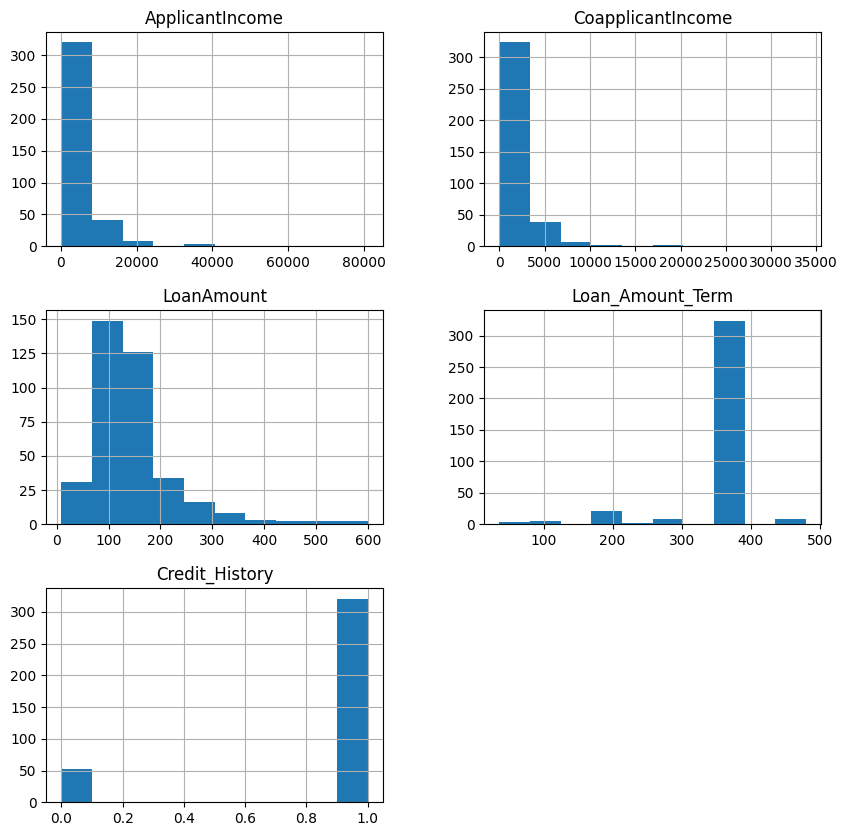

In [13]:
import matplotlib.pyplot as plt
train_features_df.hist(figsize=(10, 10))
plt.show()

The dataset has lots of loans for people that dont make that much money and they also are not borrowing that much money either.

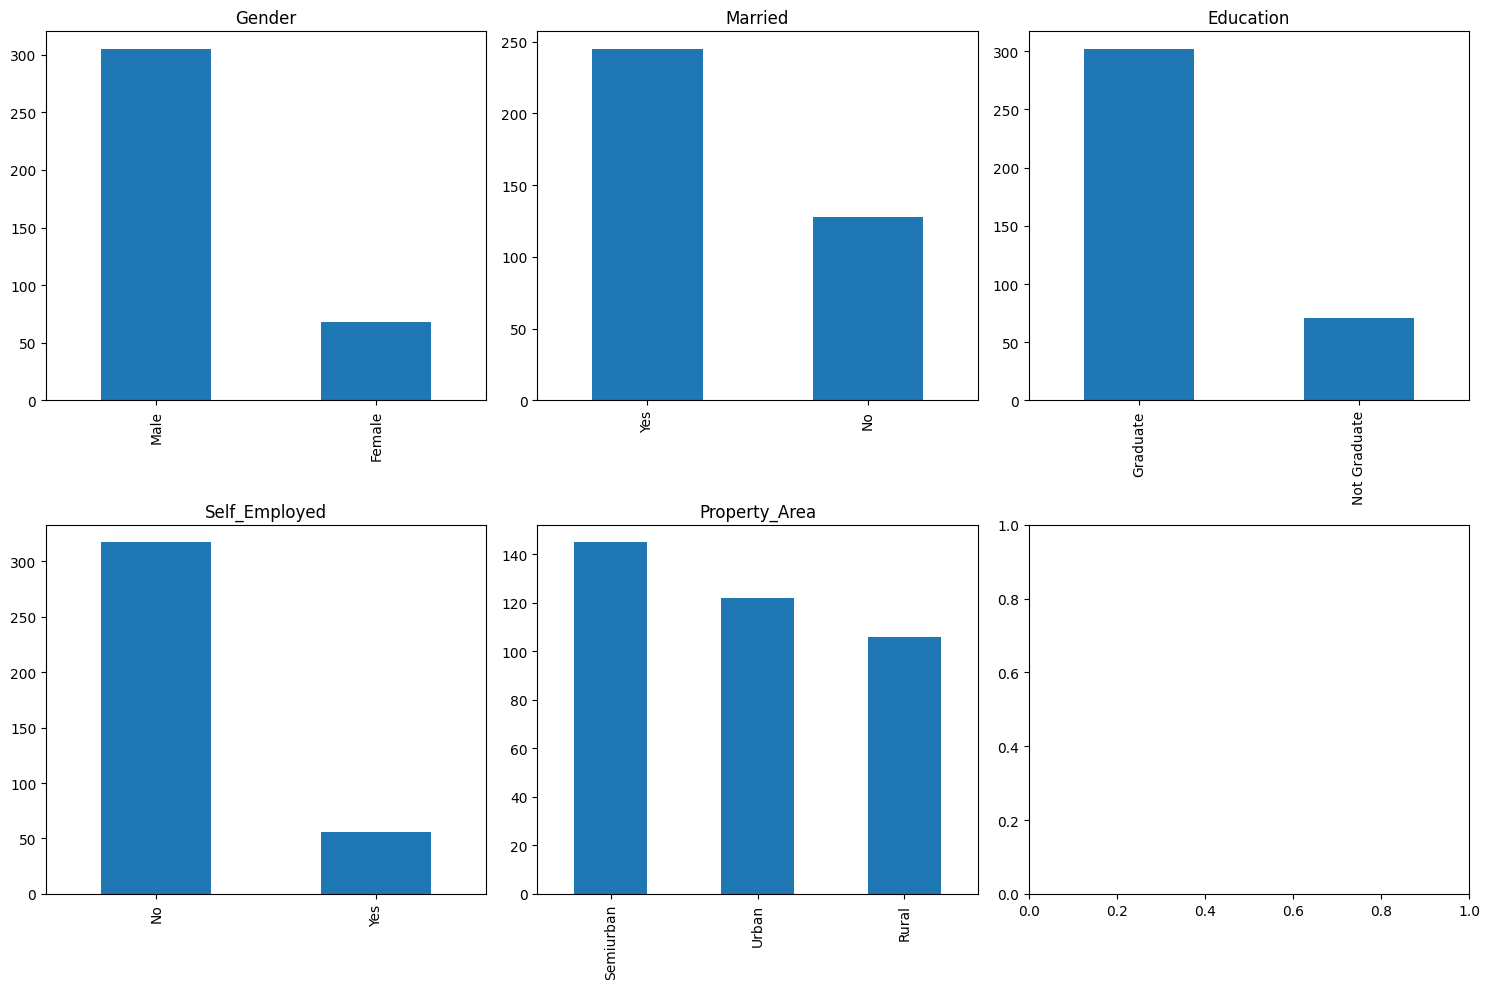

In [14]:
columns = ["Gender", "Married", "Education", "Self_Employed", "Property_Area"]
categorical_features = set(["Gender", "Married", "Self_Employed", "Property_Area", "Credit_History"])

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, column in enumerate(columns):
  row_index = i // 3
  col_index = i % 3
  train_features_df[column].value_counts().plot(kind='bar', ax=axes[row_index, col_index])
  axes[row_index, col_index].set_title(column)

plt.tight_layout()
plt.show()

And here we have the counts for the categorical variables, looks like we have many more males taking out loans and more people who are married than not.

Now lets implement the Decision Tree model. \\
The splitting criteria will be the gini index given by:
$$Gini(p) = 1 - \sum_{i=1}^{c}p_i^2$$
where $c$ is the number of classes (2 for us), and $p_i$ is the proportion of examples that fall under the ith class

In [15]:
def gini(p):
  label_counts = p.value_counts()
  probabilities = label_counts / p.shape[0]
  return 1 - sum(probabilities ** 2)

First define a node in our decision tree

In [16]:
class Node:
  def __init__(self, feature=None, threshold=None, values=None, left=None, right=None):
    self.feature = feature
    self.threshold = threshold
    self.values = values
    self.left = left
    self.right = right

  def is_leaf(self):
    return self.label_counts is not None

`feature` is the feature on which the node splits.

`threshold` is the threshold for the node's split.

`values`, for leaf nodes this will be the number of examples that have label 'Y' or 'N'.

`left` and `right` are the left and right children of this Node

And now lets write out the code for building the tree

In [17]:
class DecisionTree:
  def __init__(self, num_features=None, max_depth=1000):
    self.num_features = num_features
    self.max_depth = max_depth
    self.root = None

`num_features`is the number of features for our tree

`max_depth` is the max depth we will allow the tree to grow to

`root` is the root of the tree

To fit our model we just set the root to the node thats returned after we recursively split

In [18]:
def fit(self, X, y):
  self.root = self.grow_tree(X, y, depth=0)

`X` is the features, `y` is the labels

In [19]:
def grow_tree(self, X, y, depth):
  # stop growing if we have reached max depth or only samples of 1 label left
  if depth >= self.max_depth or y.nunqique() == 1:
    return Node(values=y)

  best_feature, best_threshold = self.best_split(X, y)
  left_idxs, right_idxs = self.split(X, best_feature, best_threshold)

  left = self.grow_tree(X[left_idxs, :], y[left_idxs, :], depth+1)
  right = self.grow_tree(X[right_idxs, :], y[right_idxs, :], depth+1)
  return Node(feature=best_feature, threshold=best_threshold, left=left, right=right)

We now need to implement the `best_split(X, y)` method to get the split for each decision in the tree

In [20]:
def best_split(self, X, y):
  best_gain = -1
  split_idx, split_thresh = None, None
  for feature in X.columns:
    X_column = X[feature]
    for threshold in X_column.unique():
      gini = self.information_gain(X, y, feature, threshold)
      if gini > best_gain:
        best_gain = gini
        best_feature = feature
        best_threshold = threshold
  return best_feature, best_threshold

Just iterate through all the feature and all the possible split points and calculate the gini index, chosing the min of these as the best split. Now for the actual calculation in `information_gain(X, y, feature, threshold)` \\

for this we will use

$$ Gini Gain = Gini_{Parent} - \sum_{children} Weight_{child} * Gini_{Child} $$

In [21]:
def information_gain(self, X, y, feature, threshold):
  categorical_features = set(["Gender", "Married", "Self_Employed", "Property_Area", "Credit_History"])
  left_idxs, right_idxs = self.split(X, feature, threshold)

  num_samples = X.shape[0]
  left_proportion, right_proportion = left_idxs.shape[0] / num_samples, right_idxs.shape[0] / num_samples

  gini_parent = gini(y)
  gini_children = left_proportion * gini(y[left_idxs, :]) + right_proportion * gini(y[right_idxs, :])

  return gini_parent - gini_children

Now for the `split(X, feature, threshold)` function we have been showing to divide the dataset \\
Note that some of our features are categorical and some are continuous so we must be weary of that when splitting

In [22]:
def split(self, X, feature, threshold):
  if feature in categorical_features:
    left_idxs = X[X[feature] == threshold].index
    right_idxs = X[X[feature] != threshold].index
  else:
    left_idxs = X[X[feature] >= threshold].index
    right_idxs = X[X[feature] < threshold].index

  return left_idxs, right_idxs

Lastly we will want to be able to get our trees prediction so lets implement a `predict(self, X)` method to traverse the tree

In [23]:
import numpy as np

def predict(self, X):
  return np.array([self.get_prediction(x, self.root) for x in X])

def get_prediction(self, x, node):
  if node.is_leaf:
    return node.values.value_counts(normalize=True).get('Y', 0.0)

  if node.feature in categorical_features:
    if x[node.feature] == node.threshold:
      return self.get_prediction(x, node.left)
    else:
      return self.get_prediction(x, node.right)

  if x[node.feature] >= node.threshold:
    return self.get_prediction(x, node.left)
  else:
    return self.get_prediction(x, node.right)

For each leaf node I am returning the proportion of 'Y' examples as a probabilty so I can make an ROC curve later on

Putting all this together we have our Decision Tree Model

In [24]:
import numpy as np

def gini(p):
  label_counts = p.value_counts()
  probabilities = label_counts / p.shape[0]
  return 1 - sum(probabilities ** 2)

class DecisionTree:
  def __init__(self, num_features=None, max_depth=1000):
    self.num_features = num_features
    self.max_depth = max_depth
    self.root = None

  def fit(self, X, y):
    self.root = self.grow_tree(X, y, depth=0)

  def grow_tree(self, X, y, depth):
    # stop growing if we have reached max depth or only samples of 1 label left
    if depth >= self.max_depth or y.nunqique() == 1:
      return Node(values=y)

    best_feature, best_threshold = self.best_split(X, y)
    left_idxs, right_idxs = self.split(X, best_feature, best_threshold)

    left = self.grow_tree(X[left_idxs, :], y[left_idxs, :], depth+1)
    right = self.grow_tree(X[right_idxs, :], y[right_idxs, :], depth+1)
    return Node(feature=best_feature, threshold=best_threshold, left=left, right=right)

  def best_split(self, X, y):
    best_gain = -1
    split_idx, split_thresh = None, None
    for feature in X.columns:
      X_column = X[feature]
      for threshold in X_column.unique():
        gini = self.information_gain(X, y, feature, threshold)
        if gini > best_gain:
          best_gain = gini
          best_feature = feature
          best_threshold = threshold
    return best_feature, best_threshold

  def information_gain(self, X, y, feature, threshold):
    categorical_features = set(["Gender", "Married", "Self_Employed", "Property_Area", "Credit_History"])
    left_idxs, right_idxs = self.split(X, feature, threshold)

    num_samples = X.shape[0]
    left_proportion, right_proportion = left_idxs.shape[0] / num_samples, right_idxs.shape[0] / num_samples

    gini_parent = gini(y)
    gini_children = left_proportion * gini(y[left_idxs, :]) + right_proportion * gini(y[right_idxs, :])

    return gini_parent - gini_children

  def split(self, X, feature, threshold):
    if feature in categorical_features:
      left_idxs = X[X[feature] == threshold].index
      right_idxs = X[X[feature] != threshold].index
    else:
      left_idxs = X[X[feature] >= threshold].index
      right_idxs = X[X[feature] < threshold].index

    return left_idxs, right_idxs

  def predict(self, X):
    return np.array([self.get_prediction(x, self.root) for x in X])

  def get_prediction(self, x, node):
    if node.is_leaf:
      return node.values.value_counts(normalize=True).get('Y', 0.0)

    if node.feature in categorical_features:
      if x[node.feature] == node.threshold:
        return self.get_prediction(x, node.left)
      else:
        return self.get_prediction(x, node.right)

    if x[node.feature] >= node.threshold:
      return self.get_prediction(x, node.left)
    else:
      return self.get_prediction(x, node.right)